<a href="https://colab.research.google.com/github/kallviktor/RandomInterpolationGAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb

In [ ]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


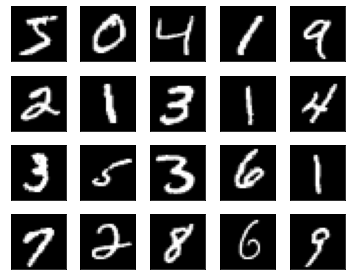

In [ ]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [ ]:
generator = keras.Sequential([
    layers.Dense(128, input_shape=(100,)),
    layers.LeakyReLU(alpha=0.01),
    layers.Dense(784),
    layers.Activation('tanh')
], name='generator')

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation (Activation)      (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
discriminator = Sequential([
    Dense(128, input_shape=(784,)),
    LeakyReLU(alpha=0.01),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

test


In [ ]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

In [ ]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [ ]:
make_trainable(discriminator, False)
discriminator.summary()

In [ ]:
make_trainable(discriminator, True)
discriminator.summary()

In [ ]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [ ]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [ ]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [ ]:
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [ ]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [ ]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

In [ ]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

In [ ]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [ ]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
def testtt_func():
    print('Hello')